In [1]:
import matplotlib.pyplot as plt
import numpy as np
from   numpy.linalg import inv
import numpy.random as npr
from   pypolyagamma import PyPolyaGamma
from scipy.stats import multivariate_normal

import matplotlib.cm as cm
from tqdm import tqdm

import pandas as pd
import statsmodels.api as sm
import scipy
import scipy.optimize as opt
import seaborn as sns

from bayesian_statistics.utils import lamda, generate_IPP, multi_pgdraw_vectorized, plot_events, plot_intensity


## データの生成

In [2]:
T = 5
beta_true = np.array([2, 7, -4])

X, y, t, z = generate_IPP(T, beta_true, background=False)

print(f"Number of presence: {len(y[y==1])}")
print(f"Number of absence: {len(y[y==0])}")

Number of presence: 142
Number of absence: 0


In [7]:
t[y==0]

array([], dtype=float64)

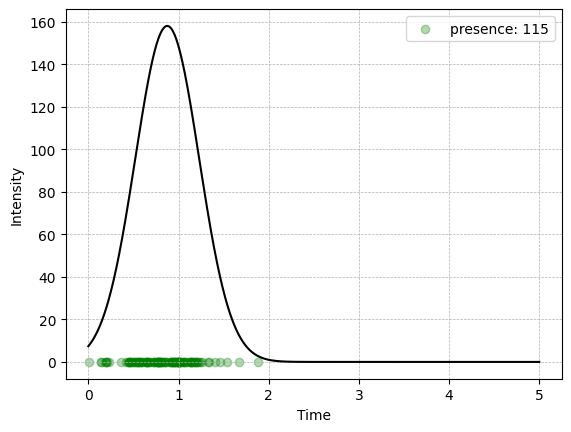

In [8]:
plot_events([], t[y==1], T, beta_true)

In [11]:
# 観測データ

## ベイズ推定

In [9]:
from   numpy.linalg import inv
import numpy.random as npr
from   pypolyagamma import PyPolyaGamma

def multi_pgdraw(pg, B, C):
    """Utility function for calling `pgdraw` on every pair in vectors B, C.
    """
    return np.array([pg.pgdraw(b, c) for b, c in zip(B, C)])

In [20]:
# prior mean and variance for beta.
b = np.zeros(3)
B = np.diag(np.ones(3))

# Peform Gibbs sampling for SIM iterations.
pg         = PyPolyaGamma()
SIM          = 80000
beta_hat   = npr.multivariate_normal(b, B)
k          = y - z/2

beta_list = []
for _ in tqdm(range(SIM)):
    # ω ~ PG(z, x*β).
    Omega_diag = multi_pgdraw(pg, z, X @ beta_hat)
    # β ~ N(m, V).
    V         = inv(X.T @ np.diag(Omega_diag) @ X + inv(B))
    m         = np.dot(V, X.T @ k + inv(B) @ b)
    beta_hat  = npr.multivariate_normal(m, V)
    beta_list.append(beta_hat)
    
beta_list = np.array(beta_list)

  2%|▏         | 1405/80000 [00:07<06:33, 199.81it/s]


KeyboardInterrupt: 

In [15]:
# beta_listをcsvに保存
pd.DataFrame(beta_list).to_csv("beta_list.csv")
print("finished!")

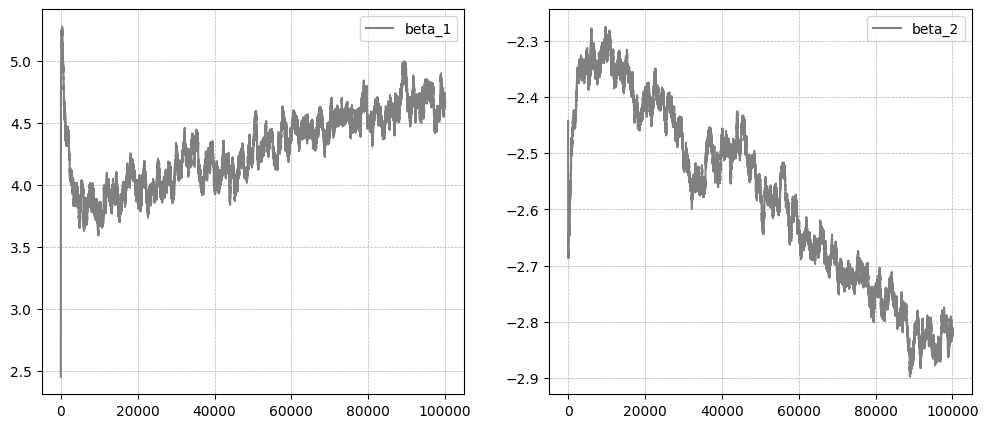

True beta: [ 4  7 -4]
MPE beta: [-9.36331199  4.29193797 -2.57884753]


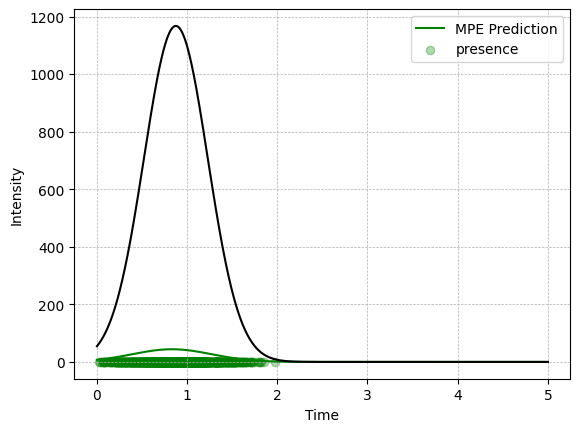

In [8]:
plt.figure(figsize=(12, 5))
#plt.title('Posterior Distribution of Beta')
# beta_list[:, 0]をTを横軸にしてプロット
plt.subplot(1, 2, 1)
plt.plot(beta_list[:, 1], c='grey', label='beta_1')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(beta_list[:, 2], c='grey', label='beta_2')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend()

plt.show()

beta_mpe = beta_list[15:].mean(axis=0)
print(f"True beta: {beta_true}")
print(f"MPE beta: {beta_mpe}")

# alpaだけは適当な値を設定
beta_mpe[0] = 2

x_lin = np.linspace(0, 5, 1000)
intensity = lamda(x_lin, beta_mpe)
plt.plot(x_lin, intensity, c='green', label='MPE Prediction')
plt.scatter(t[y==1], np.zeros(len(t[y==1])), c='green', alpha=0.3, label='presence')
plt.plot(x_lin, lamda(x_lin, beta_true), c='black')

plt.xlabel('Time')
plt.ylabel('Intensity')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend()
plt.show()
